In [25]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [26]:
# setup pytorch gpu
print(torch.cuda.is_available())
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
12.1


In [27]:
#get file names
rotation_files = glob.glob('data\processed\*rotations*.pkl')
rotation_files[0].split('\\')[1:]
rotation_files = [x.split('\\')[1] + '/' + x.split('\\')[-1][:-6] for x in rotation_files]
#remove duplicates
rotation_files = set(rotation_files)

In [39]:
#load saved files

def file_loader(fname, reformat):
    """
    Loads saved data (in this specific project)
    """
    with open(f'./data/{fname}_x.pkl', 'rb') as f:
        firing_rates = pickle.load(f)
    with open(f'./data/{fname}_y.pkl', 'rb') as f:
        y_np = pickle.load(f)
    print(f'loaded data: X ({firing_rates.shape}), y ({y_np.shape})')
    
    num_cats = len(np.unique(y_np))

    if reformat:
        #format X as tensor of reordered dims to run CNNs
        firing_rates = torch.from_numpy(firing_rates).permute(2, 0, 1) 
        firing_rates = firing_rates.to(torch.float32)
        #don't format y here to keep dims for later
        y = y_np
    else:
        y = y_np

    return firing_rates, y, num_cats

firing_rates_all = []
ys = []
nums_cats = []

cutoff_size = 50

for fname in rotation_files:
    firing_rates, y, num_cats = file_loader(fname, reformat=True)
    if firing_rates.shape[2] > cutoff_size:
        firing_rates_all.append(firing_rates)
        ys.append(y)
        nums_cats.append(num_cats)
    else:
        print(f'{fname} skipped due to too little neurons!')

loaded data: X ((3645, 81, 252)), y ((3645,))
loaded data: X ((3645, 125, 252)), y ((3645,))
loaded data: X ((3645, 69, 252)), y ((3645,))
loaded data: X ((9452, 93, 252)), y ((9452,))
loaded data: X ((9448, 89, 252)), y ((9448,))
loaded data: X ((3645, 73, 252)), y ((3645,))
loaded data: X ((9451, 38, 252)), y ((9451,))
processed/3_rotations skipped due to too little neurons!
loaded data: X ((3645, 49, 252)), y ((3645,))
processed/5_rotations skipped due to too little neurons!
loaded data: X ((9452, 114, 252)), y ((9452,))
loaded data: X ((9454, 73, 252)), y ((9454,))


In [40]:
#join ys
y = np.concat(ys)# #format y as one hot encoding
y = F.one_hot(torch.from_numpy(y).to(torch.int64))
y = y.to(torch.float32)

In [41]:
# standardize dims by size
min_size = np.min([rates.shape[2] for rates in firing_rates_all])
num_cats = np.max([cats for cats in nums_cats])
print(f'the lowest amount of neurons to standardize to: {min_size}\n number of categories in data: {num_cats}')

the lowest amount of neurons to standardize to: 69
 number of categories in data: 7


In [42]:
#standardize data to min size
#ensure that most active units are kept: they are sorted by firing rate
#maybe a more natural option is to drop random units, as they are sampled?
ids = [np.sort((np.random.random(min_size) * rate.shape[2]).astype(int)) for rate in firing_rates_all]
firing_rates_all = [rate[:,:,id] for rate, id in zip(firing_rates_all, ids)]

In [43]:
for rate in firing_rates_all:
    print(rate.shape)
#the neurons should be sorted - check 

torch.Size([252, 3645, 69])
torch.Size([252, 3645, 69])
torch.Size([252, 3645, 69])
torch.Size([252, 9452, 69])
torch.Size([252, 9448, 69])
torch.Size([252, 3645, 69])
torch.Size([252, 9452, 69])
torch.Size([252, 9454, 69])


torch.Size([252, 3645, 69])


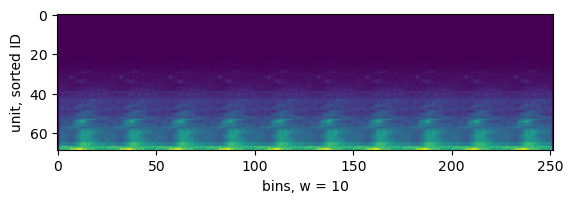

torch.Size([252, 3645, 69])


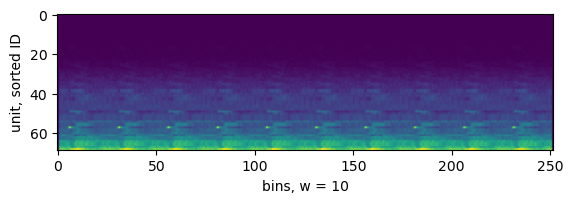

torch.Size([252, 3645, 69])


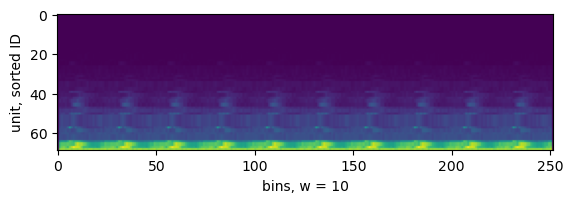

torch.Size([252, 9452, 69])


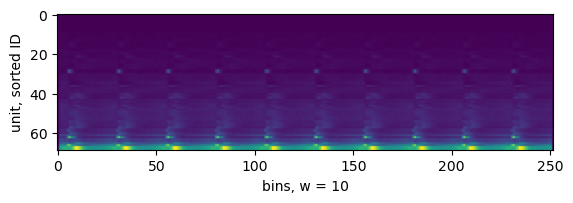

torch.Size([252, 9448, 69])


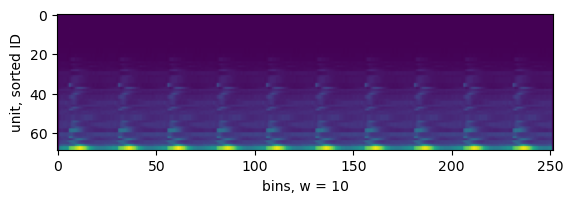

torch.Size([252, 3645, 69])


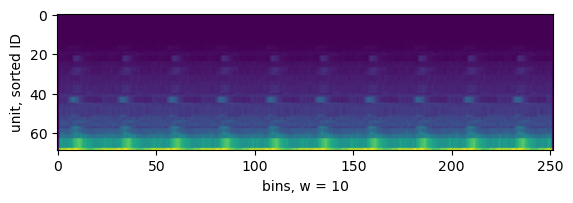

torch.Size([252, 9452, 69])


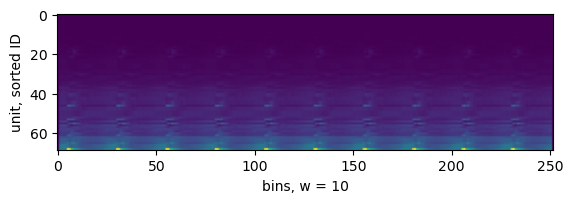

torch.Size([252, 9454, 69])


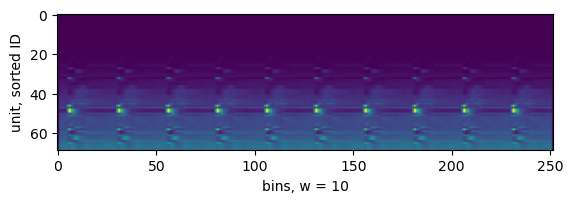

In [44]:
for rate in firing_rates_all:
    fig, ax = plt.subplots()
    print(rate.shape)
    ax.imshow(torch.mean(rate, dim= 1).T)
    ax.set(xlabel = 'bins, w = 10', ylabel = 'unit, sorted ID')
    plt.show()

In [45]:
#stack data
firing_rates = torch.cat(firing_rates_all, dim = 1)

In [46]:
#train test split
train_split = .8
all_ids = np.arange(firing_rates.shape[1])
np.random.shuffle(all_ids)
train_ids = all_ids[0:int(len(all_ids) * train_split)]
test_ids = all_ids[int(len(all_ids) * train_split):-1]

In [47]:
n_neurons = firing_rates.shape[-1] #number of units: size of input layer
n_bins = firing_rates.shape[0] #always 252 when defined as before
output_cats = num_cats #7cats here

#param for dataloader
batch_size = 32

n_comps = 7 #n of latent comps to try
learning_rate = 1e-3 #big LR to converge quickly (hopefully)
lambda_l2 = 5e-3 #big l2 regularization
num_epochs = 20 #100 definitely enough, but after ~50 slows down considerably if lr=1e-4. 
#with lr=1e-3 10 might be enough
earlystop_criterion = 20 #how many iters of loss worsening before stopping

In [48]:
#define model architecture
class Net(nn.Module):
    def __init__(self, n_comps, n_neurons, output_cats):
        super(Net, self).__init__()
        
        #layers
        #1st conv -> relu -> maxpool block 
        #size: 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )
        #2nd conv -> relu -> maxpool block
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )

        # get the flattened size by using a dummy tensor of the same size
        dummy = torch.zeros(1, 1, n_bins, n_neurons)
        out = self.conv2(self.conv1(dummy))
        flattened_size = torch.flatten(out, 1).shape[1]

        #add a dropout layer
        self.dropout = nn.Dropout(p = 0.2)
        #1st fully connected layer for flattened data
        self.fc1 = nn.Linear(flattened_size, n_comps) #here, layer size depends on input data
        #2nd fully connected layer for dim reduction
        self.fc2 = nn.Linear(n_comps, output_cats)
    
    def forward(self, x):
        x = self.conv1(x)#conv
        x = self.conv2(x)#conv
        x = torch.flatten(x, 1) #flatten params
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [49]:
class NeuralData(Dataset):
    def __init__(self, train = True):
        if train:
            self.firing_rate = firing_rates[:, train_ids, :]
            self.labels = y[train_ids]
        else:
            self.firing_rate = firing_rates[:, test_ids, :]
            self.labels = y[test_ids]
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        rate = self.firing_rate[:, idx]
        # rate = torch.sum(self.firing_rate, axis = 0)[idx]
        label = self.labels[idx]
        return rate, label
    
train_data = NeuralData(train = True)
test_data = NeuralData(train = False)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [50]:
comps_to_try = [7, 25, 50]
accs = []
losses = []

for n_comps in comps_to_try:
    train_data = NeuralData(train = True)
    test_data = NeuralData(train = False)

    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)
    #create model
    model = Net(n_comps = n_comps, n_neurons = n_neurons, output_cats = output_cats)

    #loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    loss_list = []
    loss_increase = 0
    prev_loss = 5

    #train
    for epoch in tqdm.tqdm(range(num_epochs)):
        #iterate through train data
        for rate, label in train_loader:
            rate = rate.unsqueeze(1)
            #forward pass 
            pred = model(rate)
            
            l2 = 0
            for p in model.parameters():
                l2 += torch.sum(p ** 2)
            loss = criterion(pred, label) + lambda_l2 * l2
            loss_list.append(loss.item())
            
            #early stopping
            if loss > prev_loss:
                loss_increase += 1
                prev_loss = loss
                if loss_increase > earlystop_criterion:
                    print(f'Early stop at epoch {epoch}, loss = {loss}, didn\'t improve for {earlystop_criterion} iterations')            
            else:
                loss_increase = 0
                prev_loss = loss
                
            #backprop
            optimizer.zero_grad() #zero out grads
            loss.backward() #calculate grad
            optimizer.step() #take step

        print(f'epoch: {epoch}, loss: {loss}')
            
    # testing
    model.eval()
    model.to(device)
    real_labels, predicted_labels = [], []
    with torch.no_grad():
        correct = 0
        total = 0
        for rate, labels in test_loader:
            #load labels
            rate, labels = rate.to(device), labels.to(device)
            rate = rate.unsqueeze(1)
            val, labels = torch.max(labels.data, 1)
            real_labels += list(labels.cpu().numpy())
            #get preds
            preds = model(rate)
            val, predicted = torch.max(preds.data, 1)
            predicted_labels += list(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accs.append((correct / total)*100)
        losses.append(loss_list)
        print(f"test acc from rates using {n_comps} hidden dims: {(correct / total)*100:.3f}%")

  5%|▌         | 1/20 [00:40<12:40, 40.04s/it]

epoch: 0, loss: 1.5615665912628174


 10%|█         | 2/20 [01:20<12:09, 40.55s/it]

epoch: 1, loss: 1.6438649892807007


 15%|█▌        | 3/20 [02:01<11:33, 40.77s/it]

epoch: 2, loss: 1.5193692445755005


 20%|██        | 4/20 [02:43<10:54, 40.90s/it]

epoch: 3, loss: 1.3933032751083374


 25%|██▌       | 5/20 [03:24<10:14, 40.94s/it]

epoch: 4, loss: 1.5320812463760376


 30%|███       | 6/20 [04:05<09:33, 40.97s/it]

epoch: 5, loss: 1.5431770086288452


 35%|███▌      | 7/20 [04:45<08:51, 40.89s/it]

epoch: 6, loss: 1.6753010749816895


 40%|████      | 8/20 [05:26<08:10, 40.88s/it]

epoch: 7, loss: 1.535843014717102


 45%|████▌     | 9/20 [06:07<07:29, 40.90s/it]

epoch: 8, loss: 1.3519318103790283


 50%|█████     | 10/20 [06:48<06:49, 40.91s/it]

epoch: 9, loss: 1.3888481855392456


 55%|█████▌    | 11/20 [07:29<06:07, 40.87s/it]

epoch: 10, loss: 1.5493226051330566


 60%|██████    | 12/20 [08:09<05:26, 40.76s/it]

epoch: 11, loss: 1.5112100839614868


 65%|██████▌   | 13/20 [08:50<04:45, 40.73s/it]

epoch: 12, loss: 1.574739933013916


 70%|███████   | 14/20 [09:30<04:03, 40.57s/it]

epoch: 13, loss: 1.3784279823303223


 75%|███████▌  | 15/20 [10:11<03:22, 40.55s/it]

epoch: 14, loss: 1.774792194366455


 80%|████████  | 16/20 [10:51<02:42, 40.56s/it]

epoch: 15, loss: 1.4422757625579834


 85%|████████▌ | 17/20 [11:32<02:01, 40.47s/it]

epoch: 16, loss: 1.5829225778579712


 90%|█████████ | 18/20 [12:12<01:20, 40.44s/it]

epoch: 17, loss: 1.531724214553833


 95%|█████████▌| 19/20 [12:52<00:40, 40.44s/it]

epoch: 18, loss: 1.4778558015823364


100%|██████████| 20/20 [13:28<00:00, 40.44s/it]

epoch: 19, loss: 1.4088562726974487


test acc from rates using 7 hidden dims: 26.553%


  5%|▌         | 1/20 [00:41<13:16, 41.90s/it]

epoch: 0, loss: 1.4552075862884521


 10%|█         | 2/20 [01:23<12:34, 41.92s/it]

epoch: 1, loss: 1.3867454528808594


 15%|█▌        | 3/20 [02:05<11:53, 41.96s/it]

epoch: 2, loss: 1.4539717435836792


 20%|██        | 4/20 [02:48<11:14, 42.15s/it]

epoch: 3, loss: 1.5088307857513428


 25%|██▌       | 5/20 [03:30<10:32, 42.15s/it]

epoch: 4, loss: 1.490463376045227


 30%|███       | 6/20 [04:12<09:48, 42.01s/it]

epoch: 5, loss: 1.5607423782348633


 35%|███▌      | 7/20 [04:54<09:06, 42.03s/it]

epoch: 6, loss: 1.5338163375854492


 40%|████      | 8/20 [05:36<08:24, 42.06s/it]

epoch: 7, loss: 1.4012467861175537


 45%|████▌     | 9/20 [06:18<07:43, 42.12s/it]

epoch: 8, loss: 1.4295015335083008


 50%|█████     | 10/20 [07:00<07:00, 42.03s/it]

epoch: 9, loss: 1.509615182876587


 55%|█████▌    | 11/20 [07:42<06:18, 42.01s/it]

epoch: 10, loss: 1.5780130624771118


 60%|██████    | 12/20 [08:24<05:35, 41.96s/it]

epoch: 11, loss: 1.5548776388168335


 65%|██████▌   | 13/20 [09:05<04:52, 41.85s/it]

epoch: 12, loss: 1.6640924215316772


 70%|███████   | 14/20 [09:47<04:10, 41.81s/it]

epoch: 13, loss: 1.5888904333114624


 75%|███████▌  | 15/20 [10:28<03:27, 41.55s/it]

epoch: 14, loss: 1.6690605878829956


 80%|████████  | 16/20 [11:08<02:44, 41.11s/it]

epoch: 15, loss: 1.5205309391021729


 85%|████████▌ | 17/20 [11:44<01:58, 39.52s/it]

epoch: 16, loss: 1.3791961669921875


 90%|█████████ | 18/20 [12:26<01:20, 40.28s/it]

epoch: 17, loss: 1.4566117525100708


 95%|█████████▌| 19/20 [13:08<00:40, 40.68s/it]

epoch: 18, loss: 1.6042087078094482


100%|██████████| 20/20 [13:43<00:00, 41.18s/it]

epoch: 19, loss: 1.421183705329895


test acc from rates using 25 hidden dims: 25.303%


  5%|▌         | 1/20 [00:35<11:15, 35.54s/it]

epoch: 0, loss: 1.7990446090698242


 10%|█         | 2/20 [01:13<11:03, 36.87s/it]

epoch: 1, loss: 1.4182517528533936


 15%|█▌        | 3/20 [01:58<11:28, 40.51s/it]

epoch: 2, loss: 1.617355465888977


 20%|██        | 4/20 [02:42<11:14, 42.17s/it]

epoch: 3, loss: 1.6208713054656982


 25%|██▌       | 5/20 [03:27<10:46, 43.09s/it]

epoch: 4, loss: 1.624090552330017


 30%|███       | 6/20 [04:12<10:10, 43.57s/it]

epoch: 5, loss: 1.481052279472351


 35%|███▌      | 7/20 [04:51<09:06, 42.04s/it]

epoch: 6, loss: 1.6326857805252075


 40%|████      | 8/20 [05:26<07:59, 39.93s/it]

epoch: 7, loss: 1.5176113843917847


 45%|████▌     | 9/20 [06:01<07:02, 38.44s/it]

epoch: 8, loss: 1.5091462135314941


 50%|█████     | 10/20 [06:36<06:14, 37.45s/it]

epoch: 9, loss: 1.4540432691574097


 55%|█████▌    | 11/20 [07:11<05:30, 36.75s/it]

epoch: 10, loss: 1.5668748617172241


 60%|██████    | 12/20 [07:47<04:51, 36.45s/it]

epoch: 11, loss: 1.6196755170822144


 65%|██████▌   | 13/20 [08:23<04:13, 36.14s/it]

epoch: 12, loss: 1.647745966911316


 70%|███████   | 14/20 [08:58<03:35, 35.95s/it]

epoch: 13, loss: 1.4402636289596558


 75%|███████▌  | 15/20 [09:37<03:03, 36.72s/it]

epoch: 14, loss: 1.5578147172927856


 80%|████████  | 16/20 [10:21<02:36, 39.02s/it]

epoch: 15, loss: 1.6720049381256104


 85%|████████▌ | 17/20 [11:00<01:56, 38.93s/it]

epoch: 16, loss: 1.5639591217041016


 90%|█████████ | 18/20 [11:40<01:18, 39.32s/it]

epoch: 17, loss: 1.6421977281570435


 95%|█████████▌| 19/20 [12:25<00:40, 40.91s/it]

epoch: 18, loss: 1.5810877084732056


100%|██████████| 20/20 [13:09<00:00, 39.46s/it]

epoch: 19, loss: 1.6824010610580444


test acc from rates using 50 hidden dims: 25.799%


for 7 simulus category classification max accuracy is given by 7 comps


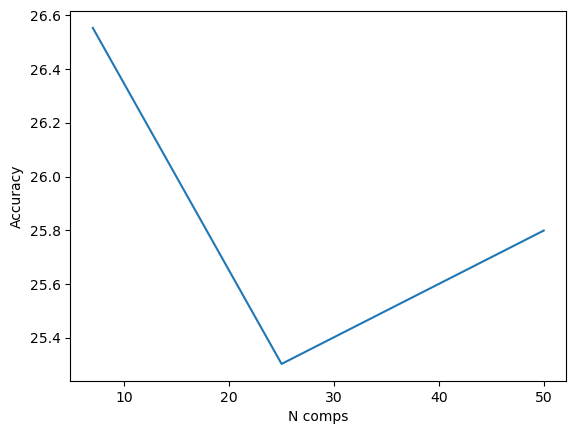

In [56]:
plt.plot(comps_to_try, accs)
plt.xlabel('N comps')
plt.ylabel('Accuracy')
# task is too easy?
# will need to standardize all inputs to have the same neuron size if going for comparison between animals
print(f'for 7 simulus category classification max accuracy is given by {comps_to_try[np.argmax(accs)]} comps')

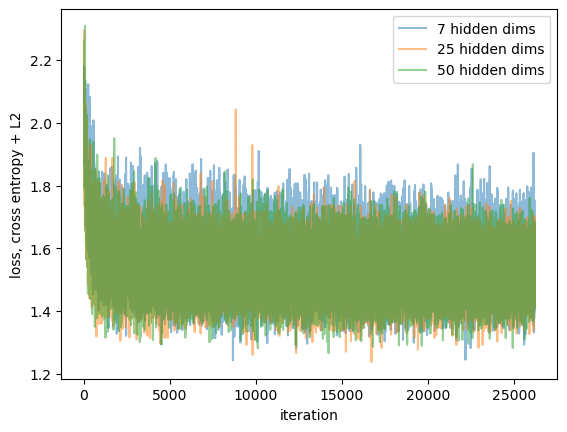

In [57]:
for i, loss_list in enumerate(losses):
    plt.plot(loss_list, label = f'{comps_to_try[i]} hidden dims', alpha = 0.5) 
    plt.xlabel('iteration')
    plt.ylabel('loss, cross entropy + L2')

plt.legend()
plt.show()

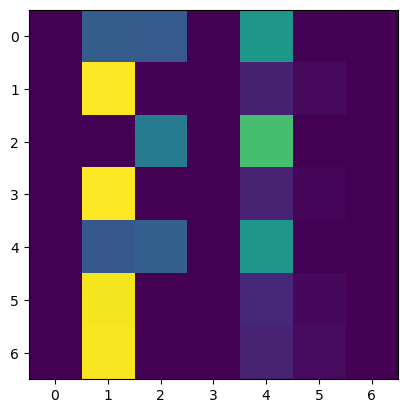

In [52]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(real_labels, predicted_labels, normalize = 'true'))

In [53]:
confusion_matrix(real_labels, predicted_labels)

array([[   0,  732,  709,    0, 1314,   17,    0],
       [   0,  706,    0,    0,   62,   18,    0],
       [   0,    0,  710,    0, 1225,    0,    0],
       [   0,  678,    0,    0,   65,   13,    0],
       [   0,  662,  732,    0, 1271,    3,    0],
       [   0,  737,    0,    0,   83,   16,    0],
       [   0,  643,    0,    0,   62,   19,    0]])

In [54]:
#save model for the future in case
with open('models/cnn_model_rotations.pkl', 'wb') as f:
    pickle.dump(model, f)

In [55]:
for i, layer in enumerate(model.parameters()):
    print(f'layer {i} num of params: {torch.numel(layer)}')

layer 0 num of params: 576
layer 1 num of params: 64
layer 2 num of params: 18432
layer 3 num of params: 32
layer 4 num of params: 96000
layer 5 num of params: 50
layer 6 num of params: 350
layer 7 num of params: 7
